# Solve observable tica on X and Y

In [2]:
import numpy as np
from scipy.linalg import solve_discrete_lyapunov
from sklearn import decomposition
import matplotlib.pyplot as plt
%matplotlib inline
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories
from matplotlib import cm
from pyemma.coordinates import tica

from msmbuilder.featurizer import AtomPairsFeaturizer
pairs = []
for i in range(22):
    for j in range(i):
        pairs.append((j,i))
X = AtomPairsFeaturizer(pairs).fit_transform(trajs)

from msmbuilder.featurizer import DihedralFeaturizer
Y = DihedralFeaturizer().fit_transform(trajs)

lag = 1

epsilon = .1

X_pca = decomposition.PCA(whiten=True, n_components = 1-epsilon)
X_pca.fit(np.vstack(X))
X_whitened = [X_pca.transform(x) for x in X]




X_0 = np.vstack([x[:-lag] for x in X_whitened])
X_tau = np.vstack([x[lag:] for x in X_whitened])

X_0 = np.insert(X_0, len(X_0[0]), 1, axis=1)
X_tau = np.insert(X_tau, len(X_tau[0]), 1, axis=1)

K_xx_tuple = np.linalg.lstsq(X_0, X_tau)
K_xx = K_xx_tuple[0]

Y_pca = decomposition.PCA(whiten=True, n_components = 1-epsilon)
Y_pca.fit(np.vstack(Y))
Y_whitened = [Y_pca.transform(y) for y in Y]

Y_0 = np.vstack([y[:-lag] for y in Y_whitened])
Y_tau = np.vstack([y[lag:] for y in Y_whitened])
                  
Y_0 = np.insert(Y_0, len(Y_0[0]), 1, axis=1)
Y_tau = np.insert(Y_tau, len(Y_tau[0]), 1, axis=1)

K_xy_tuple = np.linalg.lstsq(X_0, Y_tau)
K_xy = K_xy_tuple[0]

s = np.linalg.svd(K_xy, compute_uv=False)


/Applications/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda/envs/py3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


alanine_dipeptide already is cached


In [3]:
print(np.linalg.eigvalsh(K_xx))
v_x = np.linalg.eigh(K_xx)[1][-1]
chi_bar = np.vstack(X_whitened).mean(0)
gamma_bar = np.vstack(Y_whitened).mean(0)

print(len(chi_bar))

chi_bar = np.insert(chi_bar, len(chi_bar), 1)
gamma_bar = np.insert(gamma_bar, len(gamma_bar), 1)

print(len(chi_bar))


A = K_xx - np.outer(v_x, chi_bar)
B = K_xy - np.outer(v_x, gamma_bar)

Q = np.dot(B, B.T)


[ 0.40009266  0.43621731  0.4422051   0.5087564   0.51387447  0.56732213
  0.77059698  0.92800665  0.93583566  0.96580726  1.00000048]
10
11


In [4]:
O = solve_discrete_lyapunov(A, Q)


In [5]:
u, s, v = np.linalg.svd(O)


In [6]:
X_transformed = np.dot(X_0, u)


# Solve regular tica on X and Y independently

In [10]:
obj_x = tica(np.vstack(X), lag = 1, dim = 2).get_output()[0]
obj_x = np.array(obj_x)

In [11]:
obj_y = tica(np.vstack(Y), lag = 1, dim = 2).get_output()[0]
obj_y = np.array(obj_y)

# Measuring the correlation between Obs_tic0, Obs_tic1, X_tic0, X_tic1, Y_tic0, Y_tic1

In [12]:
obs_tic0 = X_transformed[:,0]
obs_tic1 = X_transformed[:,1]
x_tic0 = obj_x.T[0]
x_tic1 = obj_x.T[1]
y_tic0 = obj_y.T[0]
y_tic1 = obj_y.T[1]

print (len(obs_tic0), len(obs_tic1), len(x_tic0), len(x_tic1), len(y_tic0), len(y_tic1))

99989 99989 99999 99999 99999 99999


In [15]:
a = [obs_tic0, obs_tic1, x_tic0[:99989], x_tic1[:99989], y_tic0[:99989], y_tic1[:99989]]
a_names = ['obs_tic0', 'obs_tic1', 'x_tic0', 'x_tic1', 'y_tic0', 'y_tic1']
# np.cov(a, rowvar = False)
for i in range(len(a)):
    for j in range(i):
        print (np.corrcoef(a[j], a[i]), (a_names[j], a_names[i]))

[[  1.00000000e+00  -4.90647311e-05]
 [ -4.90647311e-05   1.00000000e+00]] ('obs_tic0', 'obs_tic1')
[[ 1.         -0.95870288]
 [-0.95870288  1.        ]] ('obs_tic0', 'x_tic0')
[[ 1.          0.02576255]
 [ 0.02576255  1.        ]] ('obs_tic1', 'x_tic0')
[[  1.00000000e+00  -5.49496944e-04]
 [ -5.49496944e-04   1.00000000e+00]] ('obs_tic0', 'x_tic1')
[[ 1.          0.06498081]
 [ 0.06498081  1.        ]] ('obs_tic1', 'x_tic1')
[[  1.00000000e+00  -9.33791480e-05]
 [ -9.33791480e-05   1.00000000e+00]] ('x_tic0', 'x_tic1')
[[ 1.         -0.95754556]
 [-0.95754556  1.        ]] ('obs_tic0', 'y_tic0')
[[ 1.          0.02089949]
 [ 0.02089949  1.        ]] ('obs_tic1', 'y_tic0')
[[ 1.          0.99838434]
 [ 0.99838434  1.        ]] ('x_tic0', 'y_tic0')
[[ 1.         -0.00188041]
 [-0.00188041  1.        ]] ('x_tic1', 'y_tic0')
[[ 1.          0.01458641]
 [ 0.01458641  1.        ]] ('obs_tic0', 'y_tic1')
[[ 1.          0.47487663]
 [ 0.47487663  1.        ]] ('obs_tic1', 'y_tic1')
[[ 1.   

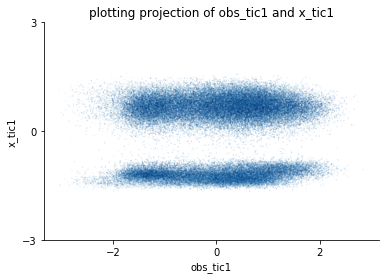

In [24]:
def make_plot(i,j):
    ax = plt.subplot(111)
    plt.scatter(a[i],a[j], c=range(len(X_transformed[:,0])), cmap=cm.Blues, s=.01,alpha=0.75)
    plt.xlabel(a_names[i])
    plt.ylabel(a_names[j])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks([-2,0,2])
    plt.yticks([-3,0,3])
    label = 'plotting projection of '+a_names[i]+ ' and '+a_names[j]
    plt.title(label)
make_plot(1,3)